In [1]:
import os
import numpy as np
import tensorflow as tf
import h5py
import math

In [2]:
def load_dataset():
    train_dataset = h5py.File('dataset/hdf5_train_dataset.hdf5', 'r')
    train_set_x_orig = np.array(train_dataset['train_set_X'][:])
    train_set_y_orig = np.array(train_dataset['train_set_Y'][:])
    
    test_dataset = h5py.File('dataset/hdf5_test_dataset.hdf5', 'r')
    test_set_x_orig = np.array(test_dataset['test_set_X'][:])
    test_set_y_orig = np.array(test_dataset['test_set_Y'][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

In [3]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    X -- input data, of shape (input size, number of examples)(m, n_H, n_W, n_C)
    Y -- true 'label' vector (containing 0 if cat, 1 if non-cat) of shape (1, number of examples)(m,n_y)
    mini_batch_size -- size of minibatches, integer
    """
    m = X.shape()   #number of examples
    mini_batches = []
    
    #Step 1 -- Shuffle X and Y
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]
    
    #Step 2 -- partition of X and Y minus the end case
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for i in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[i*mini_batch_size: i* mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[i*mini_batch_size: i*mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    #handling the end case (last_mini_batch < mini_batch_size)
    if m%mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size:m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches*mini_batch_size:m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches
    

In [4]:
def convert_to_one_hot(Y,C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [5]:
def forward_propagation_for_predict(X, parameters):
    
    """Implement Linear -> Relu -> Linear -> ReLu -> Softmax
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit 
    
    """
    #Retrieve the parameters from the dictionary 'parameters'
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2), b3)
    
    return Z3

In [6]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
 
    params = {"W1" : W1,
             "b1" : b1,
             "W2" : W2,
             "b2" : b2, 
             "W3" : W3,
              "b3" : b3
             }
    x = tf.placeholder("float", [12288,1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x:X})
    
    return prediction

# Residual network

In [7]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


## Identity Block

In [8]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block.
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    #Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    #Retrieve filters
    F1, F2, F3 = filters
    
    #Save the i/p value 
    X_shortcut = X
    
    #First Component of the main path
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', 
               name = conv_name_base + '2a', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    #Second Component of the main path
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', 
               name = conv_name_base + '2b', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    #Third Component
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', 
               name = conv_name_base + '2c', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    #Add shortcut to the main path
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    


## Convolution Block

In [9]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    #retrieve filters
    F1,F2,F3 = filters
    
    #Save the input value
    X_shortcut = X
    
    #Main Path
    #First component of the main path
    X = Conv2D(F1, (1,1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    #Second component of the main path
    X = Conv2D(F2, (f,f), strides = (1,1), name = conv_name_base + '2b', 
                   padding  = 'same', kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    #Third component 
    X = Conv2D(F3, (1,1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer=glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    #Shortcut Path
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    
    #Final Step
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

## Building ResNet50

In [10]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [11]:
model = ResNet50(input_shape=(64,64,3), classes = 6)

In [12]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset()
#Normalise Image vectors
X_train = X_train_orig/255.
X_test  =X_test_orig/255.

#Convert Training and test labels to one hot vectors
Y_train = convert_to_one_hot(Y_train_orig,6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 8000
number of test examples = 2000
X_train shape: (8000, 64, 64, 3)
Y_train shape: (8000, 6)
X_test shape: (2000, 64, 64, 3)
Y_test shape: (2000, 6)


In [14]:
X_train_orig.shape

(8000, 64, 64, 3)

In [15]:
history = model.fit(X_train, Y_train, epochs = 70, batch_size = 32)

Epoch 1/70
8000/8000 [==============================] - 666s 83ms/step - loss: 1.1821 - acc: 0.5135
Epoch 2/70
8000/8000 [==============================] - 655s 82ms/step - loss: 0.9565 - acc: 0.5346
Epoch 3/70
8000/8000 [==============================] - 671s 84ms/step - loss: 0.8476 - acc: 0.5734
Epoch 4/70
8000/8000 [==============================] - 671s 84ms/step - loss: 0.8864 - acc: 0.5926
Epoch 5/70
8000/8000 [==============================] - 678s 85ms/step - loss: 0.9197 - acc: 0.6111
Epoch 6/70
8000/8000 [==============================] - 680s 85ms/step - loss: 0.8834 - acc: 0.6125
Epoch 7/70
8000/8000 [==============================] - 656s 82ms/step - loss: 0.7760 - acc: 0.6461
Epoch 8/70
8000/8000 [==============================] - 666s 83ms/step - loss: 0.8495 - acc: 0.6573
Epoch 9/70
8000/8000 [==============================] - 654s 82ms/step - loss: 0.8967 - acc: 0.6054
Epoch 10/70
8000/8000 [==============================] - 651s 81ms/step - loss: 0.8555 - acc: 0.6345

In [23]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

2000/2000 [==============================] - 33s 17ms/step
Loss = 1.59646500397
Test Accuracy = 0.7235


dict_keys(['loss', 'acc'])


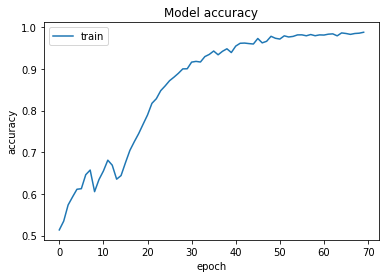

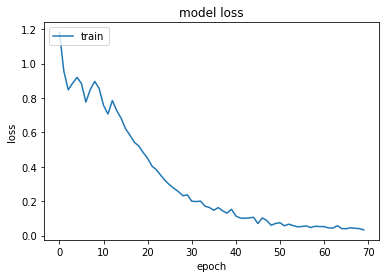

In [27]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()